# TraitGym [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/songlab-cal/TraitGym/blob/main/TraitGym.ipynb)
In this example we will load the Mendelian traits dataset and run variant effect prediction based on euclidean distance of GPN-Animal-Promoter embeddings of the reference and alternate sequences.

## Setup

In [1]:
!pip install -q pyfaidx s3fs git+https://github.com/songlab-cal/gpn.git
!pip install -q -U transformers datasets

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.7/77.7 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.5/151.5 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 67.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.8/185.8 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.4/181.4 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 75.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 73.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
from Bio.Seq import Seq
from datasets import load_dataset
import fsspec
import gpn.model  # to register AutoModel
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
from pyfaidx import Fasta
import seaborn as sns
from sklearn.metrics import average_precision_score
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel, TrainingArguments, Trainer
import tempfile

In [3]:
dataset_path = "songlab/TraitGym"
dataset_config = "mendelian_traits"
model_path = "songlab/gpn-animal-promoter"
# in the paper we average with the predictions with the reverse complement
# however for a quick evaluation you can omit this
average_rc = False

## Load dataset

In [4]:
dataset = load_dataset(dataset_path, dataset_config, split="test")
dataset

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/563 [00:00<?, ?B/s]

test.parquet:   0%|          | 0.00/50.2k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/3380 [00:00<?, ? examples/s]

Dataset({
    features: ['chrom', 'pos', 'ref', 'alt', 'OMIM', 'consequence', 'label', 'tss_dist', 'match_group'],
    num_rows: 3380
})

In [5]:
dataset[0]

{'chrom': '1',
 'pos': 1425822,
 'ref': 'C',
 'alt': 'G',
 'OMIM': None,
 'consequence': 'PLS',
 'label': False,
 'tss_dist': 48,
 'match_group': 'PLS_4'}

In [6]:
# if you just want a dataframe you can load it directly:
# pd.read_parquet("hf://datasets/songlab/TraitGym/mendelian_traits_matched_9/test.parquet")
V = dataset.to_pandas()
V

,chrom,pos,ref,alt,OMIM,consequence,label,tss_dist,match_group
0,1,1425822,C,G,None,PLS,False,48,PLS_4
1,1,1615869,C,T,None,PLS,False,35,PLS_0
2,1,1659060,G,A,None,PLS,False,47,PLS_4
3,1,1659114,A,G,None,PLS,False,101,PLS_5
4,1,2050958,T,C,None,5_prime_UTR_variant,False,149,5_prime_UTR_variant_7
...,...,...,...,...,...,...,...,...,...
3375,X,155613005,C,T,None,PLS,False,52,PLS_52
3376,X,155719093,C,A,None,5_prime_UTR_variant,False,4,5_prime_UTR_variant_101
3377,X,155881342,A,C,None,PLS,False,2,PLS_57
3378,X,155881414,C,T,None,5_prime_UTR_variant,False,35,5_prime_UTR_variant_110


## Load model

In [7]:
# Wrapper to compute a VEP score
class ModelVEP(torch.nn.Module):
    def __init__(self, model_path):
        super().__init__()
        self.model = AutoModel.from_pretrained(
            model_path,
            trust_remote_code=True,
        )

    def forward(
        self,
        input_ids_ref=None,
        input_ids_alt=None,
    ):
        embed_ref = self.model(input_ids=input_ids_ref).last_hidden_state.reshape(len(input_ids_ref), -1)
        embed_alt = self.model(input_ids=input_ids_alt).last_hidden_state.reshape(len(input_ids_ref), -1)
        return F.pairwise_distance(embed_ref, embed_alt)


class ModelVEPAverageRC(torch.nn.Module):
    def __init__(self, model_path):
        super().__init__()
        self.model = AutoModel.from_pretrained(
            model_path,
            trust_remote_code=True,
        )

    def get_scores(self, input_ids_ref, input_ids_alt):
        embed_ref = self.model(input_ids=input_ids_ref).last_hidden_state.reshape(len(input_ids_ref), -1)
        embed_alt = self.model(input_ids=input_ids_alt).last_hidden_state.reshape(len(input_ids_ref), -1)
        return F.pairwise_distance(embed_ref, embed_alt)

    def forward(
        self,
        input_ids_ref_fwd=None,
        input_ids_alt_fwd=None,
        input_ids_ref_rev=None,
        input_ids_alt_rev=None,
    ):
        fwd = self.get_scores(input_ids_ref_fwd, input_ids_alt_fwd)
        rev = self.get_scores(input_ids_ref_rev, input_ids_alt_rev)
        return (fwd + rev) / 2

In [8]:
tokenizer = AutoTokenizer.from_pretrained(model_path)
window_size = 512
if average_rc:
    model = ModelVEPAverageRC(model_path)
else:
    model = ModelVEP(model_path)

tokenizer_config.json:   0%|          | 0.00/784 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/419 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/609M [00:00<?, ?B/s]

dilation_schedule=[1, 2, 4, 8, 16, 32, 64, 128, 1, 2, 4, 8, 16, 32, 64, 128, 1, 2, 4, 8, 16, 32, 64, 128, 1, 2, 4, 8, 16, 32, 64, 128, 1, 2, 4, 8, 16, 32, 64, 128, 1, 2, 4, 8, 16, 32, 64, 128, 1, 2, 4, 8, 16, 32, 64, 128, 1, 2, 4, 8, 16, 32, 64, 128]


## Tokenize dataset

In [9]:
class Genome:
    def __init__(self, path):
        self.data = Fasta(fsspec.open(path, anon=True))

    def __call__(self, chrom, start, end, strand="+"):
        res = self.data[chrom][start:end]
        if strand == "-":
            res = res.reverse.complement
        return str(res)

In [10]:
genome = Genome("s3://broad-references/hg38/v0/Homo_sapiens_assembly38.fasta")

In [11]:
def tokenize(seqs):
    return tokenizer(
        seqs,
        padding=False,
        truncation=False,
        return_token_type_ids=False,
        return_attention_mask=False,
        return_special_tokens_mask=False,
        return_tensors="pt",
    )["input_ids"]

def get_tokenized_seq(vs):
    # we convert from 1-based coordinate (standard in VCF) to
    # 0-based, to use with Genome
    chrom = np.array(vs["chrom"])
    n = len(chrom)
    pos = np.array(vs["pos"]) - 1
    start = pos - window_size // 2
    end = pos + window_size // 2
    seq_fwd = [genome("chr" + chrom[i], start[i], end[i]) for i in range(n)]
    seq_fwd = np.array([list(seq.upper()) for seq in seq_fwd], dtype="object")
    assert seq_fwd.shape[1] == window_size
    ref_fwd = np.array(vs["ref"])
    alt_fwd = np.array(vs["alt"])
    pos_fwd = window_size // 2

    def prepare_output(seq, pos, ref, alt):
        assert (seq[:, pos] == ref).all(), f"{seq[:, pos]}, {ref}"
        seq_ref = seq
        seq_alt = seq.copy()
        seq_alt[:, pos] = alt
        return (
            tokenize(["".join(x) for x in seq_ref]),
            tokenize(["".join(x) for x in seq_alt]),
        )

    res = {}
    res["input_ids_ref"], res["input_ids_alt"] = prepare_output(seq_fwd, pos_fwd, ref_fwd, alt_fwd)
    return res

def get_tokenized_seq_average_rc(vs):
    # we convert from 1-based coordinate (standard in VCF) to
    # 0-based, to use with Genome
    chrom = np.array(vs["chrom"])
    n = len(chrom)
    pos = np.array(vs["pos"]) - 1
    start = pos - window_size // 2
    end = pos + window_size // 2
    seq_fwd = [genome("chr" + chrom[i], start[i], end[i]) for i in range(n)]
    seq_rev = [str(Seq(x).reverse_complement()) for x in seq_fwd]
    seq_fwd = np.array([list(seq.upper()) for seq in seq_fwd], dtype="object")
    seq_rev = np.array([list(seq.upper()) for seq in seq_rev], dtype="object")
    assert seq_fwd.shape[1] == window_size
    assert seq_rev.shape[1] == window_size
    ref_fwd = np.array(vs["ref"])
    alt_fwd = np.array(vs["alt"])
    ref_rev = np.array([str(Seq(x).reverse_complement()) for x in ref_fwd])
    alt_rev = np.array([str(Seq(x).reverse_complement()) for x in alt_fwd])
    pos_fwd = window_size // 2
    pos_rev = pos_fwd - 1 if window_size % 2 == 0 else pos_fwd

    def prepare_output(seq, pos, ref, alt):
        assert (seq[:, pos] == ref).all(), f"{seq[:, pos]}, {ref}"
        seq_ref = seq
        seq_alt = seq.copy()
        seq_alt[:, pos] = alt
        return (
            tokenize(["".join(x) for x in seq_ref]),
            tokenize(["".join(x) for x in seq_alt]),
        )

    res = {}
    res["input_ids_ref_fwd"], res["input_ids_alt_fwd"] = prepare_output(seq_fwd, pos_fwd, ref_fwd, alt_fwd)
    res["input_ids_ref_rev"], res["input_ids_alt_rev"] = prepare_output(seq_rev, pos_rev, ref_rev, alt_rev)
    return res

In [12]:
if average_rc:
    dataset.set_transform(get_tokenized_seq_average_rc)
else:
    dataset.set_transform(get_tokenized_seq)

In [13]:
dataset[0]

{'input_ids_ref': tensor([4, 4, 6, 5, 5, 4, 3, 5, 4, 4, 6, 5, 4, 6, 5, 3, 5, 6, 5, 4, 4, 6, 5, 4,
         4, 5, 6, 5, 6, 3, 4, 5, 5, 5, 4, 4, 4, 4, 3, 4, 3, 4, 4, 4, 6, 5, 4, 5,
         5, 4, 6, 4, 3, 4, 5, 4, 5, 4, 3, 6, 4, 4, 4, 3, 5, 5, 6, 4, 4, 4, 4, 6,
         4, 6, 4, 3, 6, 4, 4, 3, 4, 6, 4, 6, 5, 3, 5, 3, 4, 5, 4, 3, 5, 5, 4, 5,
         5, 3, 5, 5, 3, 4, 3, 4, 4, 5, 3, 4, 3, 3, 5, 5, 6, 5, 6, 6, 4, 3, 5, 3,
         6, 5, 3, 5, 5, 5, 3, 5, 4, 3, 5, 4, 5, 5, 5, 5, 4, 6, 5, 5, 5, 5, 4, 6,
         5, 5, 5, 3, 4, 3, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 4, 6, 5, 5, 4, 4,
         6, 4, 4, 3, 5, 5, 6, 5, 5, 4, 3, 5, 4, 6, 3, 4, 6, 5, 3, 6, 5, 5, 5, 5,
         4, 3, 5, 4, 6, 3, 4, 4, 5, 5, 3, 5, 6, 4, 3, 3, 5, 4, 4, 4, 6, 6, 6, 5,
         3, 3, 3, 6, 5, 3, 5, 5, 6, 4, 6, 6, 6, 5, 6, 5, 6, 5, 5, 5, 5, 5, 3, 5,
         4, 6, 5, 4, 3, 5, 4, 4, 4, 4, 5, 4, 4, 4, 5, 5, 4, 3, 4, 3, 5, 5, 5, 3,
         5, 5, 5, 3, 5, 5, 4, 5, 5, 4, 4, 4, 4, 5, 5, 6, 5, 5, 5, 3, 3, 5, 5, 5,
         4,

## Run inference

In [14]:
training_args = TrainingArguments(
    output_dir=tempfile.TemporaryDirectory().name,
    per_device_eval_batch_size=128,
    # pyfaidx does not allow multiple workers
    # for longer jobs you can use the gpn.data.Genome class,
    # which loads a local fasta file into memory and can use multiple
    # workers, see e.g.
    # https://github.com/songlab-cal/gpn/blob/main/gpn/ss/run_vep_embed_dist.py
    dataloader_num_workers=0,
    remove_unused_columns=False,
    torch_compile=False,
    fp16=True,
    report_to="none",
)
trainer = Trainer(model=model, args=training_args)
preds = trainer.predict(test_dataset=dataset).predictions
preds.shape

(3380,)

## Compute metrics

In [15]:
V["score"] = preds

In [16]:
# let's compare to the precomputed scores
# this is using RC averaging
V["precomputed_score"] = pd.read_parquet("hf://datasets/songlab/TraitGym/mendelian_traits_matched_9/features/GPN_final_EuclideanDistance.parquet").score.values
V[["score", "precomputed_score"]].corr()

,score,precomputed_score
score,1.000000,0.956949
precomputed_score,0.956949,1.000000


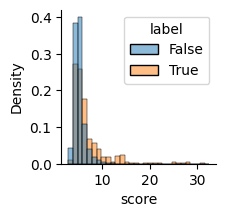

In [17]:
plt.figure(figsize=(2, 2))
sns.histplot(
    data=V, x="score", bins=30, hue="label", stat="density",
    common_norm=False, common_bins=True,
)
sns.despine();

In [18]:
# global AUPRC
average_precision_score(V.label, V.score)

0.3050859084098214

In [19]:
# AUPRC by chrom
res_by_chrom = []
for chrom in V.chrom.unique():
    V_chrom = V[V.chrom == chrom]
    res_by_chrom.append([chrom, len(V_chrom), average_precision_score(V_chrom.label, V_chrom.score)])
res_by_chrom = pd.DataFrame(res_by_chrom, columns=["chrom", "n", "AUPRC"])
res_by_chrom

,chrom,n,AUPRC
0,1,210,0.285684
1,2,230,0.317321
2,3,310,0.151283
3,5,20,1.000000
4,6,30,0.347619
5,7,210,0.192152
6,8,70,0.120540
7,9,240,0.086625
8,10,190,0.183487
9,11,480,0.285151


In [20]:
# Weighted average

def stat(df):
    weight = df["n"] / df["n"].sum()
    return (df["AUPRC"] * weight).sum()

stat(res_by_chrom)

0.3304637185530955

In [21]:
def bootstrap_se(df, stat, n_bootstraps=1000):
    df = pl.DataFrame(df)
    return (
        pl.Series([
            stat(df.sample(len(df), with_replacement=True, seed=i))
            for i in range(n_bootstraps)]
        )
        .std()
    )

bootstrap_se(res_by_chrom, stat)

0.05398842833086511

In [22]:
# compare with official results (which use RC averaging)
pd.read_csv("hf://datasets/songlab/TraitGym/mendelian_traits_matched_9/AUPRC_by_chrom_weighted_average/all/GPN_final_EuclideanDistance.plus.score.csv")

,model,metric,score,se
0,GPN_final_EuclideanDistance.plus.score,AUPRC,0.346963,0.056745
